In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import utility
import time

In [8]:
from rectangle import Rectangle
from utility import scores_completion_sorted, compute_prediction_region
from itertools import product
import math
def one_rect_prediction_regions_nD(scores, alpha = 0.2, short_cut = True):

    # Sort the transposed scores from smallest to largest coordinate-wise
    scores = np.unique(scores, axis=0) 
    scores_sorted = np.transpose(scores_completion_sorted(scores, False))
    
    # Number of samples, number of dimensions, conformal index
    n = scores.shape[0]
    d = scores.shape[1]
    level = math.ceil((1-alpha)*(n+1))/n

    # Grab the rectangle that contains the mean
    scores_mean = np.mean(np.transpose(scores), axis=1)
    abs_diff = np.abs(np.transpose(np.array([scores_mean])) - np.sort(np.transpose(scores), axis=1, kind="mergesort"))
    mask = (np.transpose(np.array([scores_mean])) - np.sort(np.transpose(scores), axis=1, kind="mergesort")) > 0
    abs_diff[mask] = np.inf 
    mean_index = np.argmin(abs_diff, axis=1)+1
    #print(mean_index)

    def create_hyper_rectangle(indices):

        upper = [scores_sorted[dim][indices[dim]] for dim in range(d)]
        lower = [scores_sorted[dim][indices[dim]-1] for dim in range(d)]

        return Rectangle(upper, lower)
    
    def binary_search_dimension(scores_sorted, fixed_indices, point, dim_along, regions, start, end):

        fix_point = np.copy(point)
        if start >= end-1:
            indices = np.copy(fixed_indices)
            indices[dim_along] = end
            rectangle = create_hyper_rectangle(indices)
            fix_point[dim_along] = rectangle.lower[dim_along]
            region = compute_prediction_region(scores, alpha, rectangle, fix_point)
            intersection = region.intersection(rectangle)
            if intersection:
                regions.append(intersection)
                #print(indices, intersection.upper)
            return

        mid = (start + end) // 2
        indices = fixed_indices[:]
        indices[dim_along] = mid
        rectangle = create_hyper_rectangle(indices)
        fix_point[dim_along] = rectangle.lower[dim_along]
        region = compute_prediction_region(scores, alpha, rectangle, fix_point)
        intersection = region.intersection(rectangle)

        if not intersection:
            binary_search_dimension(scores_sorted, fixed_indices, point, dim_along, regions, start, mid)
        #elif intersection.same_as(rectangle):
            #binary_search_dimension(scores_sorted, fixed_indices, point, dim_along, regions, mid, end)
        else:
            regions.append(intersection)
            binary_search_dimension(scores_sorted, fixed_indices, point, dim_along, regions, mid, end)

    if short_cut:
        regions = []
        max_bounds = np.zeros(d)
        for idx in range(d):
            fix_indices = np.copy(mean_index)
            fix_indices[idx] = 1
            binary_search_dimension(scores_sorted, fix_indices, scores_mean, idx, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)


        return Rectangle(upper=max_bounds)
    else:   

        regions = []
        max_bounds = np.zeros(d)
        for indices in product(range(1, n+2), repeat=d):

            indices = np.copy(indices)
            rectangle = create_hyper_rectangle(indices)

            point = np.zeros(d)
            for i in range(d):
                point[i] = scores_mean[i] if indices[i] == mean_index[i] else rectangle.lower[i]
                    

            region = compute_prediction_region(scores, alpha, rectangle, point)


            intersection = region.intersection(rectangle)
            if intersection:

                regions.append(intersection)
                max_bounds = np.maximum(max_bounds, intersection.upper)
                #print(indices, max_bounds)

        return regions, Rectangle(upper=max_bounds)

# Equivalence Evaluation

In [10]:
n_cals = np.arange(5, 11, 1)
n_trials = 500
evaluations = np.zeros(len(n_cals))
evaluations_2d = np.zeros(len(n_cals))
evaluations_3d = np.zeros(len(n_cals))
for index, n_cal in enumerate(n_cals):
    samples = n_cal*10
    evaluation_array_2d = np.zeros(n_trials)
    evaluation_array_3d = np.zeros(n_trials)
    for sample in range(n_trials):
        np.random.seed(sample)
        random_int = np.random.randint(10, 20, size = 3)

        #d=2
        X0, y0 = make_regression(n_samples=samples, n_features=random_int[0], noise= random_int[1], n_targets=2, random_state=random_int[2])
        X0_train, X0_test, X0_cal, y0_train, y0_test, y0_cal = utility.calibration_split(X0, y0)
        model0 = LinearRegression()
        model0.fit(X0_train, y0_train)
        prediction0 = model0.predict(X0_cal)
        scores0 = np.abs(prediction0 - y0_cal)
        regions0, region0 = one_rect_prediction_regions_nD(scores0, alpha=0.2, short_cut = False)
        Region0 = one_rect_prediction_regions_nD(scores0)
        evaluation_array_2d[sample] = (Region0).same_as(region0)

        #d=3
        X1, y1 = make_regression(n_samples=samples, n_features=random_int[0], noise= random_int[1], n_targets=3, random_state=random_int[2])
        X1_train, X1_test, X1_cal, y1_train, y1_test, y1_cal = utility.calibration_split(X1, y1)
        model1 = LinearRegression()
        model1.fit(X1_train, y1_train)
        prediction1 = model1.predict(X1_cal)
        scores1 = np.abs(prediction1 - y1_cal)
        regions1, region1 = one_rect_prediction_regions_nD(scores1, alpha=0.2, short_cut = False)
        Region1 = one_rect_prediction_regions_nD(scores1)
        evaluation_array_3d[sample] = (Region1).same_as(region1)

        
    evaluations_2d[index] = np.sum(evaluation_array_2d)/n_trials
    evaluations_3d[index] = np.sum(evaluation_array_3d)/n_trials
    print(f"In the cases of {n_cal} calibration points with {n_trials} many trials:\n{evaluations_2d[index]*100} percent regions are the same in 2D and {evaluations_3d[index]*100} percent regions are the same in 3D")


In the cases of 5 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D
In the cases of 6 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D
In the cases of 7 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D
In the cases of 8 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D
In the cases of 9 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D
In the cases of 10 calibration points with 500 many trials:
100.0 percent regions are the same in 2D and 100.0 percent regions are the same in 3D


## Runtime Evaluation

In [32]:
n_cals = np.arange(50, 105, 5)
runtime_2d = np.zeros((len(n_cals), 2))
runtime_3d = np.zeros((len(n_cals), 2))
for index, n_cal in enumerate(n_cals):
    samples = n_cal*10
    np.random.seed(samples)
    random_int = np.random.randint(10, 20, size = 3)

    #d=2
    X0, y0 = make_regression(n_samples=samples, n_features=random_int[0], noise= random_int[1], n_targets=2, random_state=random_int[2])
    X0_train, X0_test, X0_cal, y0_train, y0_test, y0_cal = utility.calibration_split(X0, y0)
    model0 = LinearRegression()
    model0.fit(X0_train, y0_train)
    prediction0 = model0.predict(X0_cal)
    scores0 = np.abs(prediction0 - y0_cal)

    start_nsc0 = time.time()
    regions0, region0 = one_rect_prediction_regions_nD(scores0, short_cut = False)
    end_nsc0 = time.time()
    runtime_2d[index][0] = end_nsc0-start_nsc0

    start_sc0 = time.time()
    Region0 = one_rect_prediction_regions_nD(scores0)
    end_sc0 = time.time()
    runtime_2d[index][1] = end_sc0-start_sc0

    #d=3
    X1, y1 = make_regression(n_samples=samples, n_features=random_int[0], noise= random_int[1], n_targets=3, random_state=random_int[2])
    X1_train, X1_test, X1_cal, y1_train, y1_test, y1_cal = utility.calibration_split(X1, y1)
    model1 = LinearRegression()
    model1.fit(X1_train, y1_train)
    prediction1 = model1.predict(X1_cal)
    scores1 = np.abs(prediction1 - y1_cal)

    start_nsc1 = time.time()
    regions1, region1 = one_rect_prediction_regions_nD(scores1, short_cut = False)
    end_nsc1 = time.time()
    runtime_3d[index][0] = end_nsc1-start_nsc1

    start_sc1 = time.time()
    Region1 = one_rect_prediction_regions_nD(scores1)
    end_sc1 = time.time()
    runtime_3d[index][1] = end_sc1-start_sc1
    

In [34]:
print(runtime_2d)

[[0.2146475315093994 0.0010063648223877]
 [0.2650556564331055 0.0019946098327637]
 [0.322070837020874  0.0019998550415039]
 [0.3840024471282959 0.001014232635498 ]
 [0.4176650047302246 0.000999927520752 ]
 [0.4720890522003174 0.0009031295776367]
 [0.5420215129852295 0.0019989013671875]
 [0.6072440147399902 0.0019993782043457]
 [0.6780591011047363 0.0010001659393311]
 [0.7611093521118164 0.002000093460083 ]
 [0.8493926525115967 0.0020003318786621]]


In [35]:
print(runtime_3d)

[[1.1543218612670898e+01 2.0048618316650391e-03]
 [1.5297495126724243e+01 1.9996166229248047e-03]
 [1.9311794757843018e+01 2.0058155059814453e-03]
 [2.5052149057388306e+01 1.9998550415039062e-03]
 [3.1444175958633423e+01 2.9852390289306641e-03]
 [3.6848281383514404e+01 2.0000934600830078e-03]
 [4.4751532316207886e+01 3.0043125152587891e-03]
 [5.5312131404876709e+01 2.0005702972412109e-03]
 [6.3031571626663208e+01 3.0040740966796875e-03]
 [7.4449098110198975e+01 3.0002593994140625e-03]
 [8.7792748689651489e+01 1.5017986297607422e-03]]


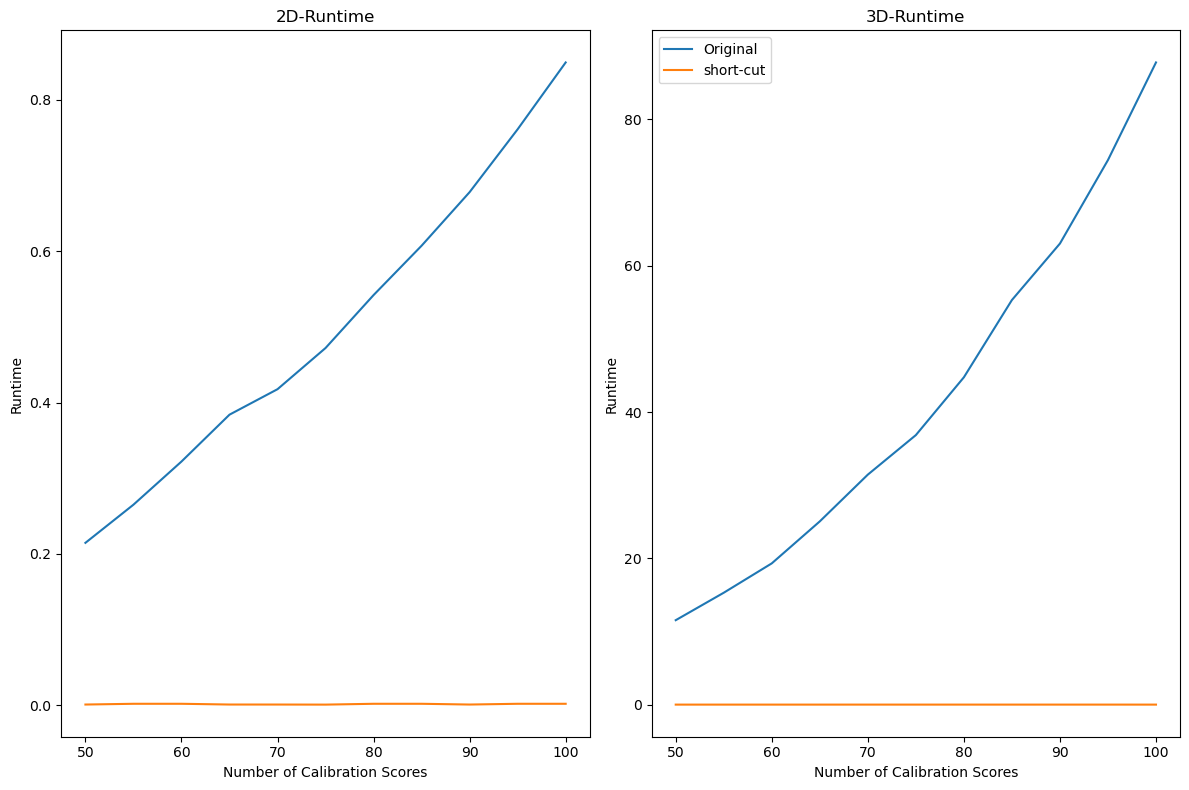

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

axes[0].plot(n_cals, np.transpose(runtime_2d)[0], label = "Original")
axes[0].plot(n_cals, np.transpose(runtime_2d)[1], label = "short-cut")
axes[0].set(title = "2D-Runtime", xlabel = "Number of Calibration Scores", ylabel = "Runtime")

axes[1].plot(n_cals, np.transpose(runtime_3d)[0], label = "Original")
axes[1].plot(n_cals, np.transpose(runtime_3d)[1], label = "short-cut")
axes[1].set(title = "3D-Runtime", xlabel = "Number of Calibration Scores", ylabel = "Runtime")

plt.legend()
plt.tight_layout()
plt.show()

In [59]:
n_cals = np.arange(50, 10000, 10)
d=10
runtime = np.zeros((d-1, len(n_cals)))
for dim in range(2, d+1):
    runtime_temp = np.zeros(len(n_cals))
    for index, n_cal in enumerate(n_cals):
        samples = n_cal*10
        np.random.seed(samples)
        random_int = np.random.randint(10, 20, size = 3)

        X0, y0 = make_regression(n_samples=samples, n_features=random_int[0], noise= random_int[1], n_targets=dim, random_state=random_int[2])
        X0_train, X0_test, X0_cal, y0_train, y0_test, y0_cal = utility.calibration_split(X0, y0)
        model0 = LinearRegression()
        model0.fit(X0_train, y0_train)
        prediction0 = model0.predict(X0_cal)
        scores0 = np.abs(prediction0 - y0_cal)

        start_sc0 = time.time()
        Region0 = one_rect_prediction_regions_nD(scores0)
        end_sc0 = time.time()
        runtime_temp[index]= end_sc0-start_sc0
    runtime[dim-2] = runtime_temp

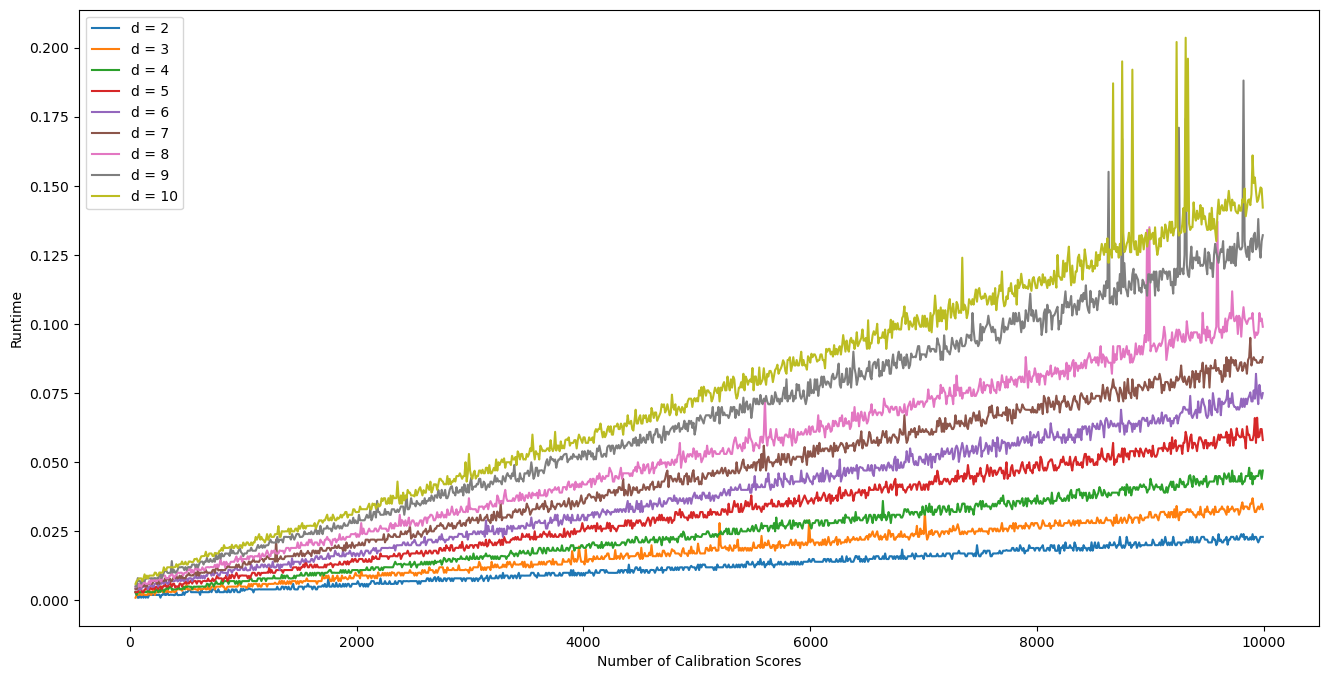

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
for index in range(d-1):
    ax.plot(n_cals, runtime[index], label = f"d = {index+2}")
ax.set(xlabel = "Number of Calibration Scores", ylabel = "Runtime")

plt.legend()
plt.show()